In [2]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from itertools import product
from dataclasses import dataclass
import os
import math
import sys
from typing import Dict, Any, List, Optional
sys.path.append('../../../../')

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd

from matplotlib.ticker import FuncFormatter

from multitask_nlp.utils.plotting import Task, get_overall_score, visualize_boxplot, plot_gain_matrix

color_pallette = 'muted'
sns.set_theme(style='whitegrid', context='talk', palette=color_pallette, 
              rc={'font.family': 'serif', 'font.serif': 'Times New Roman', 'mathtext.fontset': 'dejavuserif'})

tasks = [
    Task(name='NKJP1M', measure='accuracy_pos', 
         measure_name='Accuracy', size=25267),
    Task(name='CCPL', measure='accuracy_pos', 
         measure_name='Accuracy', size=19425),
    Task(name='pl pos tagging', measure='accuracy_pos', 
         measure_name='Accuracy')
]

cols_to_display = ['dataset', 'learning_kind', 'model_name', 'model_type', 'type', 'overall_score']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_type(row):
    ttype = row['learning_kind']
    return ttype

def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['type'] = df.apply(lambda x: get_type(x), axis=1)    
    df['overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks), axis=1)    
    return df

In [9]:
title_size = 24

def visualize_boxplot_paper(
    df: pd.DataFrame, legend_labels: Optional[List[str]] = None, cols=2,
    suptitle: str = '', bbox_to_anchor = (1.0, 1.0), loc=2, ncol=1, fig_legend=True,
    order=None, steps=True, runtimes=True, epochs=False, **kwargs
):  
    row_height = 4
    col_width = 7
    
    additional_plots_prop = []
    if runtimes:
        additional_plots_prop.append(('Runtime', 'Runtime [s]'))
    if steps:
        additional_plots_prop.append(('trainer/global_step', 'Steps'))
    if epochs:
        additional_plots_prop.append(('epoch', 'Epochs'))
        
    rows = math.ceil((1+len(additional_plots_prop)) / cols)
    if rows * cols == 1:
        fig, axis = plt.subplots(figsize=(col_width, rows*row_height), constrained_layout=True)  
        axis = [axis]
    else:
        fig, axis = plt.subplots(rows, cols, figsize=(cols*col_width, rows*row_height), constrained_layout=True)  
        axis = axis.flatten()
    
    
    id_cols = ['learning_kind', 'model_name', 'model_type', 'model_kind']   
    measures_to_plot = [f'{task.name}_test_{task.measure}' for task in tasks]
    x_ticks_labels = [f'{task.name}' for task in tasks]
    x_ticks_labels[x_ticks_labels.index('pl pos tagging')] = 'POS Overall'
    
    df_measures = pd.melt(df, id_vars=id_cols, value_vars=measures_to_plot)      
    
    ax = axis[0]
    sns.boxplot(x='variable', y='value', ax=ax, data=df_measures, **kwargs)
    ax.set_xticklabels(x_ticks_labels)           
    ax.set_xlabel(None)
    ax.set_ylabel(tasks[0].measure_name)  
    
    title = 'Performance'
    ax.set_title(title, fontsize=title_size)

    handles, labels = ax.get_legend_handles_labels()
    if ax.get_legend():
        legend_title = ax.get_legend().get_title().get_text().replace('_', ' ').capitalize()
        ax.get_legend().remove()
        if not fig_legend:
            ax.legend(handles, labels, title=legend_title, bbox_to_anchor=bbox_to_anchor, loc=loc, ncol=ncol)

    if fig_legend and len(handles) > 0: 
        fig.legend(handles, labels, title=legend_title, bbox_to_anchor=bbox_to_anchor, loc=loc, ncol=ncol)
            
    if 'hue' in kwargs:
        hue = kwargs['hue']
    else:
        hue = None
        
    if 'hue_order' in kwargs:
        hue_order = kwargs['hue_order']
    else:
        hue_order = None
    
    for (i, (column_name, ylabel)), ax in zip(enumerate(additional_plots_prop), axis[1:]):    
        sns.barplot(x='type', y=column_name, ax=ax, data=df, edgecolor='black', 
                    hue=hue, hue_order=hue_order)
        ax.set_xticklabels([])   
        ax.set_ylabel(ylabel)
        ax.set_xlabel(None)
        ax.set_title(ylabel, fontsize=title_size)

        handles, labels = ax.get_legend_handles_labels()
        if ax.get_legend():
            legend_title = ax.get_legend().get_title().get_text().replace('_', ' ').capitalize()
            ax.get_legend().remove()
            if not fig_legend:
                ax.legend(handles, labels, title=legend_title, bbox_to_anchor=bbox_to_anchor, loc=loc, ncol=ncol)

        if fig_legend and len(handles) > 0: 
            fig.legend(handles, labels, title=legend_title, bbox_to_anchor=bbox_to_anchor, loc=loc, ncol=ncol)  

    for ax in axis[1+len(additional_plots_prop):]:
        ax.axis('off')          

    fig.suptitle(suptitle)
    sns.despine(fig)

def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.1f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

def format_score(x):
    if x == 0:
        return '00.00'
    else:
        return f'{round(100*x, 2):.2f}'


In [5]:
def get_model_kind(r):
    kind = r['model_name']        
    return kind

# Eksperymenty 1

- Powtórzenia: 5
- Liczba Epok: 8
- Learning rate: 1e-4
- Max length: 256
- Batch size: 16
- Warm-up: 0.1
- Weight decay: 0.01
- Monitor: Val Loss

In [6]:
df = load_results_df('stl_pos_nkjp_eval_at_ccpl_results.csv')
df['model_kind'] = df.apply(lambda r: get_model_kind(r), axis=1)

In [6]:
# with pd.option_context('display.max_rows', None):
#     display(df[cols_to_display + ['model_kind']])
# with pd.option_context('display.max_rows', None):
#     display(df[['dataset', 'type', 'scale_class_loss', 'epoch', 'num_epochs', 'trainer/global_step', 'Runtime']])
# df['model_kind'].unique()
# df['model_kind'].value_counts()
# df.columns.values

In [7]:
measures_to_plot = [f'{task.name}_test_{task.measure}' for task in tasks]
agg_dict = {m: ['median'] for m in measures_to_plot}
df.groupby(by=['model_kind']).agg(agg_dict)

,NKJP1M_test_accuracy_pos,CCPL_test_accuracy_pos,pl pos tagging_test_accuracy_pos
,median,median,median
model_kind,,,
polish-distilroberta,0.967541,0.869539,0.896427
polish-roberta,0.971933,0.866190,0.895117


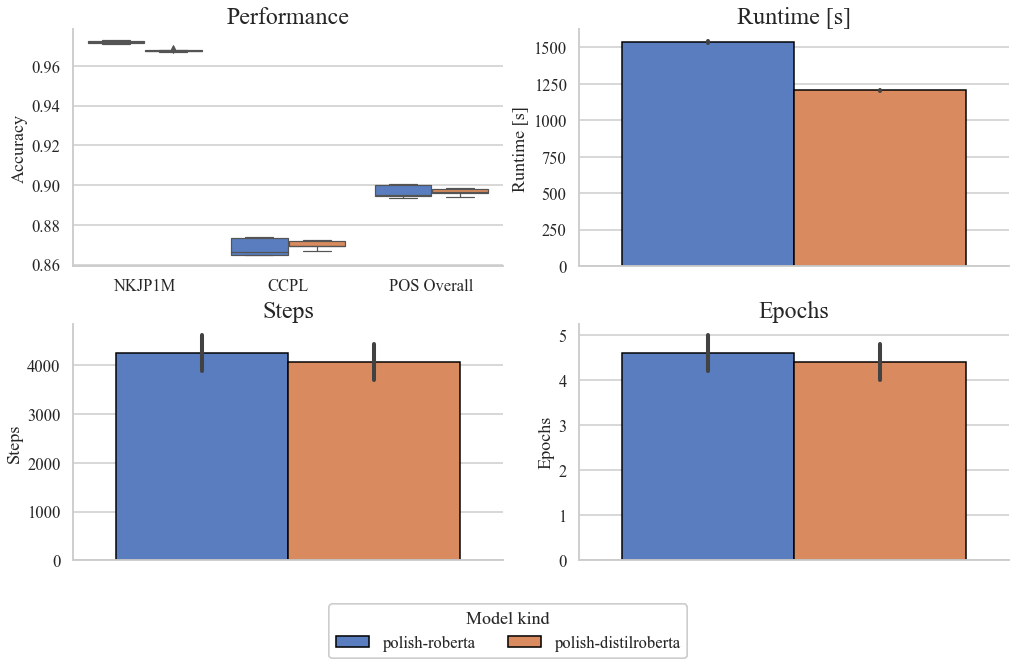

In [10]:
hue_order = ['polish-roberta', 'polish-distilroberta']
visualize_boxplot_paper(
    df, cols=2,
    showfliers=True, linewidth=1.2,
    hue='model_kind', 
    hue_order=hue_order,
    ncol=2, loc='center', bbox_to_anchor=(0.5, -0.1), fig_legend=True,
    runtimes=True, steps=True, epochs=True
)

# Eksperymenty 2

- Powtórzenia: 5
- Liczba Epok: 10
- Learning rate: 1e-4
- Max length: 256
- Batch size: 32
- Warm-up: 0.1
- Weight decay: 0.01
- Monitor: valid_overall_score

In [11]:
df = load_results_df('stl_pos_nkjp_eval_at_ccpl_results2.csv')
df['model_kind'] = df.apply(lambda r: get_model_kind(r), axis=1)

In [12]:
df.value_counts(["type", "model_kind"])

type  model_kind          
STL   polish-distilroberta    5
      polish-roberta          5
dtype: int64

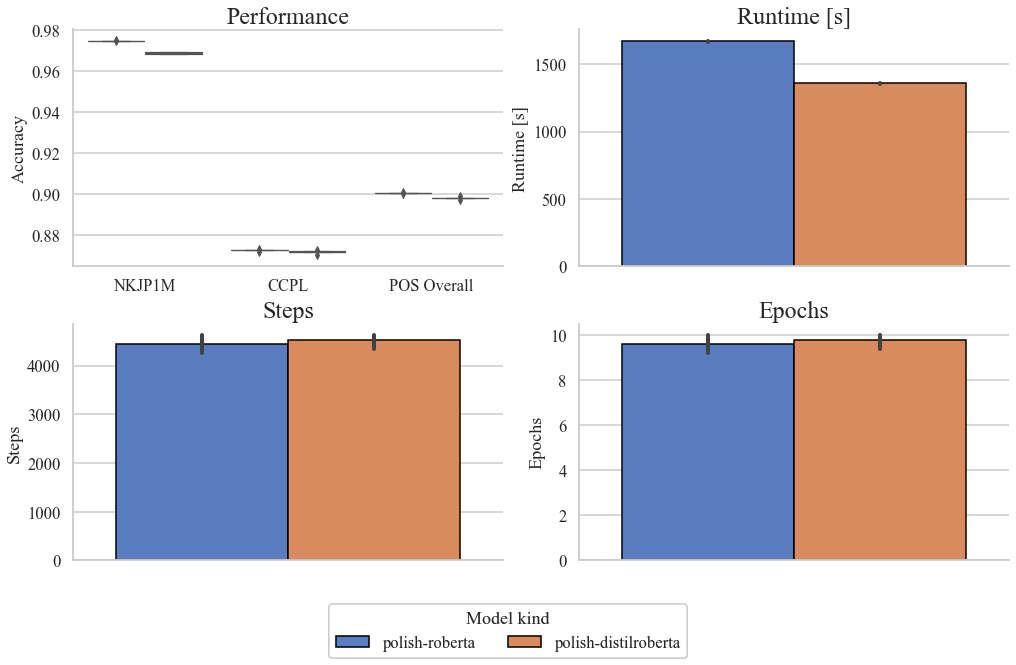

In [13]:
hue_order = ['polish-roberta', 'polish-distilroberta']
visualize_boxplot_paper(
    df, cols=2,
    showfliers=True, linewidth=1.2,
    hue='model_kind', 
    hue_order=hue_order,
    ncol=2, loc='center', bbox_to_anchor=(0.5, -0.1), fig_legend=True,
    runtimes=True, steps=True, epochs=True
)

In [15]:
measures_to_plot = [f'{task.name}_test_{task.measure}' for task in tasks]

agg_dict = {m: (m, 'median') for m in measures_to_plot}
result_df = df.groupby(by=['model_kind']).agg(**agg_dict)

for col in agg_dict.keys():
    result_df[col] = result_df[col].apply(lambda x: format_score(x))

result_df

result_df.to_csv(f'stl_pos_agg_results.csv', index=True)

In [16]:
result_df

,NKJP1M_test_accuracy_pos,CCPL_test_accuracy_pos,pl pos tagging_test_accuracy_pos
model_kind,,,
polish-distilroberta,96.86,87.16,89.80
polish-roberta,97.48,87.27,90.05
